## ELEC4840 Assignment 1

Name: 

Student ID: 

- Problem 1 (40%)

- Problem 2 (60%)

In [8]:
# import torch
# print(torch.__version__)
# print(torch.version.cuda)
# print(torch.backends.cudnn.version())
# print(torch.cuda.is_available())


In [1]:
# import packages
import torch
from torch import nn
from torchvision import datasets, transforms
from tqdm import tqdm

## HINT
You should run training on __training dataset__, validate the model's performance during training using __validation dataset__. After finishing training, select the model that has the best performance on validation dataset, then report the model's performance based on the data of the __test dataset__.

In [ ]:
# load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=0.5,
        std=0.5
    )
])

data_train = datasets.MNIST(
    root="./data/",
    transform=transform,
    train=True,
    download=True
)

data_test = datasets.MNIST(
    root="./data/",
    transform=transform,
    train=False
)

split_train_size = int(0.8*(len(data_train))) 
split_valid_size = len(data_train) - split_train_size

train_set, valid_set = torch.utils.data.random_split(
    data_train, [split_train_size, split_valid_size])

loader_train = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=64,
    shuffle=True
)

loader_valid = torch.utils.data.DataLoader(
    dataset=valid_set,
    batch_size=64,
    shuffle=False
)

loader_test = torch.utils.data.DataLoader(
    dataset=data_test,
    batch_size=64,
    shuffle=False
)

### Problem 1. Train an MLP network on the MNIST dataset (40%)

Use a four-layer MLP to train the MNIST dataset.

| Layer |  Type  |       Input       |      Output       | Activation |
| :---: | :----: | :---------------: | :---------------: | :--------: |
|   1   | Linear |      28 * 28      |         128         |    ReLU    |
|   2   | Linear |         128         |        64         |    ReLU    |
|  3  | Dropout | 64 | 64 | - |
|   4   | Linear |        64         |        32         |    ReLU    |
|  5   | Dropout | 32 | 32 | - |
|   6   | Linear |       32         |        10         |     -      |


a.) Implement the function `__init__` and `forward` in the class `Model` (15%);

b.) Implement the training code (15%).

c.) Plot the curve of accuracy and loss(5%). Compare and discuss the results' difference between the model with / without dropout operation(5%).

In [11]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        ## ----- write your code here
        self.layers = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            # nn.Dropout(0.5),      
            nn.Linear(64, 32),
            nn.ReLU(),
            # nn.Dropout(0.3),       
            nn.Linear(32, 10)
        )

    def forward(self, x):
        ## ----- write your code here
        ## Remember to return the output and delete the 'pass' command below
        x = x.view(x.size(0), -1) 
        return self.layers(x)
       
        pass

In [12]:
max_epoch = 20
use_cuda = True

# model initialization
model = Model()
if use_cuda:
    model = model.cuda()

# loss function
criterion = nn.CrossEntropyLoss()# -- write your code here --

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 0.0001, momentum = 0.98)# -- write your code here --

loss_list = []
valid_loss_list = []
acc_train_list = []
acc_valid_list = []

best_valid_loss = float('inf')

for epoch in range(max_epoch):
    running_loss = 0.0
    running_correct = 0
    valid_loss = 0.0
    valid_correct = 0
    print(" -- Epoch {}/{}".format(epoch + 1, max_epoch))

    # training
    # call a function to control the dropout behaviour 
    # your code here
    model.train()

    for data in tqdm(loader_train):
        # set all gradients to zero
        optimizer.zero_grad()

        # fetch data
        images, labels = data
        if use_cuda:
            images = images.cuda()
            labels = labels.cuda()

        # model forward
        outputs = model(images)# -- write your code here --

        # calculate loss
        loss = criterion(outputs, labels)# -- write your code here --

        loss.backward()
        optimizer.step()

        pred = torch.argmax(outputs, dim=1)
        running_loss += loss.item()
        running_correct += torch.sum(pred == labels)




    # record loss, accuracy
    loss = running_loss / len(train_set)
    loss_list.append(loss)
    acc_train = running_correct / len(train_set)
    acc_train_list.append(acc_train.item())

    # testing

    # call a function to control the dropout behaviour 
    # your code here
    model.eval()

    valid_correct = 0
    for data in loader_valid:
        # fetch data
        # model forward
        # calculate loss
        images, labels = data
        if use_cuda:
            images = images.cuda()
            labels = labels.cuda()
    
        val_outputs = model(images)
        val_loss = criterion(val_outputs, labels)
        val_pred = torch.argmax(val_outputs, dim = 1)
        
        valid_loss += val_loss.item()
        valid_correct += torch.sum(val_pred == labels)    
    

    # Save best checkpoint
    valid_loss /= len(valid_set)
    if valid_loss < best_valid_loss:# -- write your code here --:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_checkpoint_mnist.pt')
    # valid_loss = valid_loss / len(valid_set)
    valid_loss_list.append(valid_loss)
    acc_valid = valid_correct / len(valid_set)
    acc_valid_list.append(acc_valid.item())
    print("Loss {:.4f}, Train Accuracy {:.4f}%, Validation Accuracy {:.4f}%".format(
        loss,
        acc_train * 100,
        acc_valid * 100
    ))


model.load_state_dict(torch.load('best_checkpoint_mnist.pt'))

# call a function to control the dropout behaviour 
# your code here
model.eval()
correct = 0
total = 0
total = len(data_test)
with torch.no_grad():
    for images, labels in loader_test:
        # fetch data
        # model forward
        # calculate accuracy on test set

        if use_cuda:
            images = images.cuda()
            labels = labels.cuda()

        outputs = model(images)
        pred = torch.argmax(outputs, dim=1)
        correct += torch.sum(pred == labels)
        pass
acc_test=correct/total
print("Best model on test set: Test Accuracy {:.4f}%".format(
        acc_test * 100
    ))

 -- Epoch 1/20


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:09<00:00, 82.05it/s]


Loss 0.0350, Train Accuracy 19.7417%, Validation Accuracy 34.6000%
 -- Epoch 2/20


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:09<00:00, 79.37it/s]


Loss 0.0248, Train Accuracy 50.1479%, Validation Accuracy 70.5667%
 -- Epoch 3/20


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:09<00:00, 82.02it/s]


Loss 0.0118, Train Accuracy 77.1458%, Validation Accuracy 81.4583%
 -- Epoch 4/20


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:09<00:00, 82.78it/s]


Loss 0.0081, Train Accuracy 84.4688%, Validation Accuracy 85.9750%
 -- Epoch 5/20


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:09<00:00, 82.38it/s]


Loss 0.0068, Train Accuracy 87.3375%, Validation Accuracy 88.1000%
 -- Epoch 6/20


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:08<00:00, 84.04it/s]


Loss 0.0061, Train Accuracy 88.6479%, Validation Accuracy 88.1000%
 -- Epoch 7/20


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:09<00:00, 80.88it/s]


Loss 0.0056, Train Accuracy 89.4750%, Validation Accuracy 89.3000%
 -- Epoch 8/20


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:09<00:00, 80.84it/s]


Loss 0.0053, Train Accuracy 90.0562%, Validation Accuracy 89.6750%
 -- Epoch 9/20


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:09<00:00, 82.12it/s]


Loss 0.0050, Train Accuracy 90.6312%, Validation Accuracy 90.7333%
 -- Epoch 10/20


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:08<00:00, 83.53it/s]


Loss 0.0048, Train Accuracy 91.0417%, Validation Accuracy 90.9750%
 -- Epoch 11/20


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:09<00:00, 80.62it/s]


Loss 0.0045, Train Accuracy 91.5833%, Validation Accuracy 91.4333%
 -- Epoch 12/20


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:08<00:00, 83.38it/s]


Loss 0.0043, Train Accuracy 91.9521%, Validation Accuracy 91.7583%
 -- Epoch 13/20


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:09<00:00, 81.27it/s]


Loss 0.0041, Train Accuracy 92.3187%, Validation Accuracy 92.1583%
 -- Epoch 14/20


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:09<00:00, 81.41it/s]


Loss 0.0039, Train Accuracy 92.6771%, Validation Accuracy 92.3083%
 -- Epoch 15/20


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:09<00:00, 80.63it/s]


Loss 0.0038, Train Accuracy 93.0021%, Validation Accuracy 92.8667%
 -- Epoch 16/20


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:09<00:00, 80.28it/s]


Loss 0.0036, Train Accuracy 93.3917%, Validation Accuracy 93.0500%
 -- Epoch 17/20


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:09<00:00, 81.11it/s]


Loss 0.0034, Train Accuracy 93.6687%, Validation Accuracy 93.3333%
 -- Epoch 18/20


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:09<00:00, 79.95it/s]


Loss 0.0032, Train Accuracy 93.9979%, Validation Accuracy 93.8667%
 -- Epoch 19/20


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:09<00:00, 80.08it/s]


Loss 0.0031, Train Accuracy 94.2521%, Validation Accuracy 93.6583%
 -- Epoch 20/20


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:09<00:00, 81.09it/s]


Loss 0.0030, Train Accuracy 94.4937%, Validation Accuracy 93.8667%
Best model on test set: Test Accuracy 94.2000%


c.) Plot loss and accuracy curve

In the previous cell, you have recorded the loss and train/valid accuracy in `loss_list`, `acc_train_list`, and `acc_valid_list`, respectively. In this problem, you are required to plot two figures: 1.) training loss curve (5%); 2.) training and validation accuracy curves in the same figure (5%).

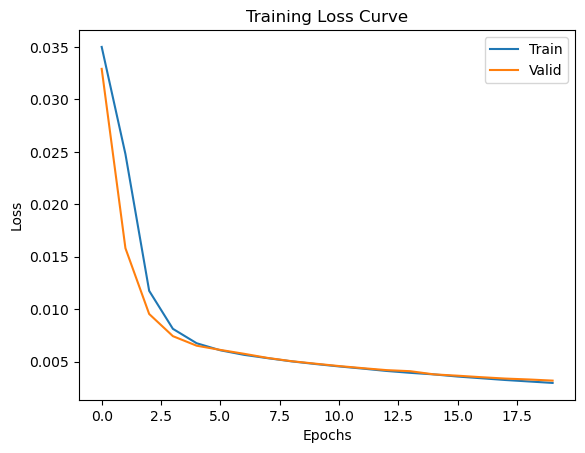

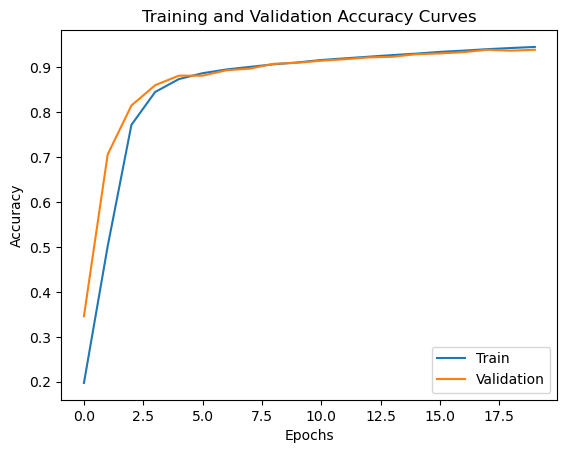

In [13]:
import numpy as np
from matplotlib import pyplot as plt

## ----- write your code here
plt.figure()
plt.plot(loss_list, label = "Train")
plt.plot(valid_loss_list, label = "Valid")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

plt.figure()
plt.plot(acc_train_list, label = "Train")
plt.plot(acc_valid_list, label = "Validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.legend()
plt.show()